# ETL Utilities

The `etl` module provides data wrangling utilities: smoothing, cross-correlation, JSON helpers, time conversions, and more.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matviz.etl import (
    nan_smooth, start_and_ends, xcorr, max_lag, round_time,
    drop_mostly_na, robust_floater, isdigit, flatten, chunks,
    load_json, dump_json, encode_floats, find_percentile,
    geometric_median, hex2rgb
)
from matviz.viz import nicefy, subplotter, title

## nan_smooth

Smooth a time series while gracefully handling NaN values.

/Users/yoni/Documents/repos/matviz/matviz/etl.py:525: RuntimeWarning: invalid value encountered in divide
  outt = ys/enss
/Users/yoni/Documents/repos/matviz/matviz/etl.py:525: RuntimeWarning: invalid value encountered in divide
  outt = ys/enss


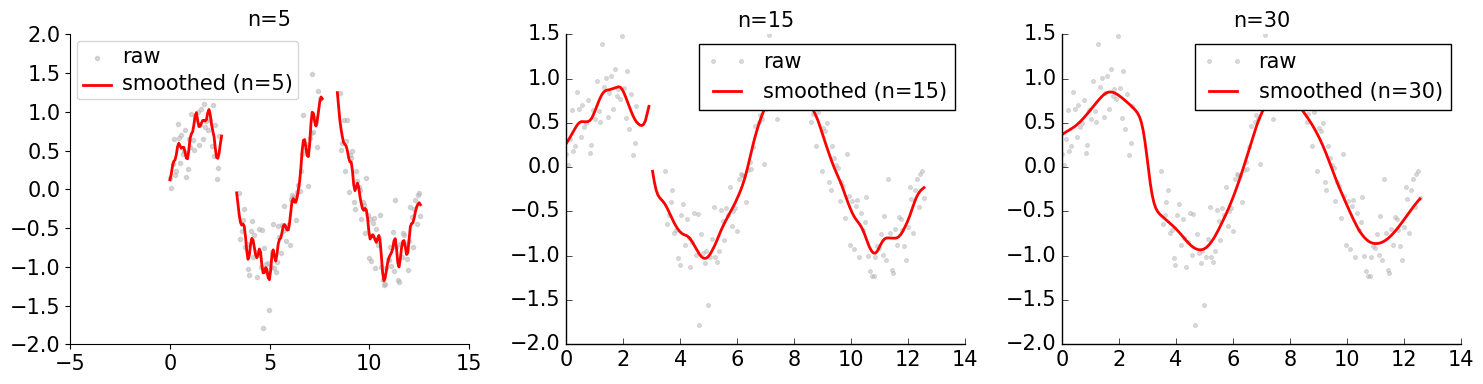

In [2]:
np.random.seed(42)
N = 200
x = np.linspace(0, 4*np.pi, N)
y = np.sin(x) + np.random.randn(N) * 0.3

# Insert some NaN gaps
y[40:55] = np.nan
y[120:135] = np.nan

plt.figure(figsize=(15, 4))

for i, (n, ttl) in enumerate(zip([5, 15, 30], ['n=5', 'n=15', 'n=30'])):
    subplotter(1, 3, i)
    plt.plot(x, y, '.', color='0.7', alpha=0.5, label='raw')
    plt.plot(x, nan_smooth(y, n=n), 'r-', lw=2, label=f'smoothed ({ttl})')
    plt.legend()
    title(ttl)
    nicefy()

plt.show()

## start_and_ends

Find contiguous True regions in a boolean array.

In [3]:
signal = np.random.randn(100).cumsum()
above_zero = signal > 0
regions = start_and_ends(above_zero)

print(f'Found {len(regions)} regions where signal > 0:')
for s, e in regions[:5]:
    print(f'  [{s}, {e}]')

Found 1 regions where signal > 0:
  [0, 99]


## xcorr / max_lag

Normalized cross-correlation and lag detection.

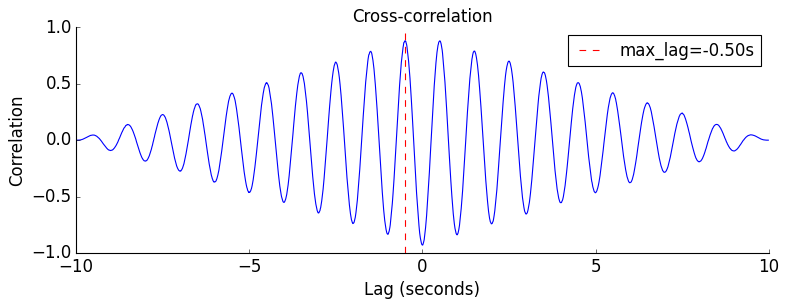

True lag: 0.5s, Detected lag: -0.500s


In [4]:
dt = 0.01
t = np.arange(0, 10, dt)
true_lag = 0.5  # seconds

a = np.sin(2 * np.pi * t) + np.random.randn(len(t)) * 0.2
b = np.sin(2 * np.pi * (t - true_lag)) + np.random.randn(len(t)) * 0.2

corrs, lags = xcorr(a, b, dt)

plt.figure(figsize=(10, 4))
plt.plot(lags, corrs)
plt.xlabel('Lag (seconds)')
plt.ylabel('Correlation')
title('Cross-correlation')

detected_lag, max_corr_val = max_lag(a, b, dt)
plt.axvline(detected_lag, color='r', linestyle='--', label=f'max_lag={detected_lag:.2f}s')
plt.legend()
nicefy()
plt.show()

print(f'True lag: {true_lag}s, Detected lag: {detected_lag:.3f}s')

## round_time and drop_mostly_na

In [5]:
import datetime

times = [datetime.datetime(2024, 1, 1, 10, 23, 45),
         datetime.datetime(2024, 1, 1, 10, 47, 12),
         datetime.datetime(2024, 1, 1, 11, 5, 30)]
rounded = round_time(times)
print('Original:', times)
print('Rounded to hour:', rounded.tolist())

Original: [datetime.datetime(2024, 1, 1, 10, 23, 45), datetime.datetime(2024, 1, 1, 10, 47, 12), datetime.datetime(2024, 1, 1, 11, 5, 30)]
Rounded to hour: [Timestamp('2024-01-01 10:00:00'), Timestamp('2024-01-01 11:00:00'), Timestamp('2024-01-01 11:00:00')]


/Users/yoni/Documents/repos/matviz/matviz/etl.py:214: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.Series(ts).dt.round(round_by)


In [6]:
df = pd.DataFrame({
    'good_col': [1, 2, 3, 4, 5],
    'sparse_col': [np.nan, np.nan, np.nan, np.nan, 1],
    'ok_col': [1, np.nan, 3, 4, 5],
})
print('Before:', df.columns.tolist())
print('After drop_mostly_na:', drop_mostly_na(df, threshold=0.5).columns.tolist())

Before: ['good_col', 'sparse_col', 'ok_col']
After drop_mostly_na: ['good_col', 'ok_col']


## robust_floater and isdigit

In [7]:
test_values = [42, '3.14', 'hello', None, np.nan, '-7']
for v in test_values:
    print(f'robust_floater({v!r}) = {robust_floater(v)}')

print()
for v in ['123', '3.14', '-5', 'abc', 42]:
    print(f'isdigit({v!r}) = {isdigit(v)}')

robust_floater(42) = 42
robust_floater('3.14') = 3.14
robust_floater('hello') = nan
robust_floater(None) = nan
robust_floater(nan) = nan
robust_floater('-7') = -7.0

isdigit('123') = True
isdigit('3.14') = True
isdigit('-5') = True
isdigit('abc') = False
isdigit(42) = True


## flatten and chunks

In [8]:
nested = np.array([np.array([1, 2, 3]), np.array([4, 5, 6]), np.array([7, 8, 9])])
print('flatten:', flatten(nested))

data = list(range(10))
print('chunks(range(10), 3):', list(chunks(data, 3)))

flatten: [1 2 3 4 5 6 7 8 9]
chunks(range(10), 3): [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9]]


## load_json / dump_json with complex numbers

In [9]:
import tempfile, os

data = {
    'name': 'test',
    'values': np.array([1+2j, 3+4j, 5+6j]),
    'scalar': 42
}

with tempfile.NamedTemporaryFile(suffix='.json', delete=False) as f:
    tmp_path = f.name

dump_json(data, tmp_path)
loaded = load_json(tmp_path)
print('Original complex:', data['values'])
print('Loaded complex:', loaded['values'])
print('Round-trip match:', np.allclose(data['values'], loaded['values']))
os.unlink(tmp_path)

Original complex: [1.+2.j 3.+4.j 5.+6.j]
Loaded complex: [1.+2.j 3.+4.j 5.+6.j]
Round-trip match: True


## encode_floats and find_percentile

In [10]:
nums = np.array([1.23456789, 0.000123, 999.9999])
print('encode_floats:', encode_floats(nums, decimals=3))

percentiles = np.percentile(np.random.randn(10000), range(101))
print(f'find_percentile(0.0) = {find_percentile(0.0, percentiles)}th percentile')

encode_floats: [Decimal('1.235'), Decimal('0.000'), Decimal('1000.000')]
find_percentile(0.0) = 51th percentile


## geometric_median

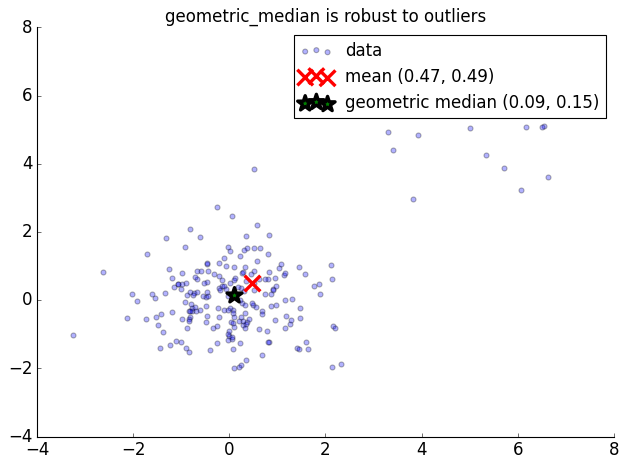

In [11]:
np.random.seed(42)
points = np.random.randn(200, 2)
# Add an outlier cluster
points = np.vstack([points, np.random.randn(20, 2) + [5, 5]])

gm = geometric_median(points)
mean = np.mean(points, axis=0)

plt.scatter(points[:, 0], points[:, 1], alpha=0.3, label='data')
plt.scatter(*mean, s=200, marker='x', c='red', lw=3, label=f'mean ({mean[0]:.2f}, {mean[1]:.2f})')
plt.scatter(*gm, s=200, marker='*', c='green', lw=3, label=f'geometric median ({gm[0]:.2f}, {gm[1]:.2f})')
plt.legend()
title('geometric_median is robust to outliers')
nicefy()
plt.show()

## DateCodec

In [12]:
from matviz.datetime_converter import DateCodec
import datetime

codec = DateCodec()

# Python datetime
dt_orig = datetime.datetime(2024, 6, 15, 12, 30, 0)
ns = codec.to_number(dt_orig)
dt_back = codec.from_number(ns)
print(f'datetime: {dt_orig} -> {ns} -> {dt_back}')

# Pandas Timestamp
codec.reset()
ts_orig = pd.Timestamp('2024-06-15 12:30:00')
ns = codec.to_number(ts_orig)
ts_back = codec.from_number(ns)
print(f'Timestamp: {ts_orig} -> {ns} -> {ts_back}')

# numpy datetime64
codec.reset()
np_orig = np.datetime64('2024-06-15T12:30:00')
ns = codec.to_number(np_orig)
np_back = codec.from_number(ns)
print(f'datetime64: {np_orig} -> {ns} -> {np_back}')

datetime: 2024-06-15 12:30:00 -> 1718454600000000000 -> 2024-06-15 12:30:00
Timestamp: 2024-06-15 12:30:00 -> 1718454600000000000 -> 2024-06-15 12:30:00
datetime64: 2024-06-15T12:30:00 -> 1718454600000000000 -> 2024-06-15T12:30:00.000000000


## circle_utils: cmake_circle and cget_area

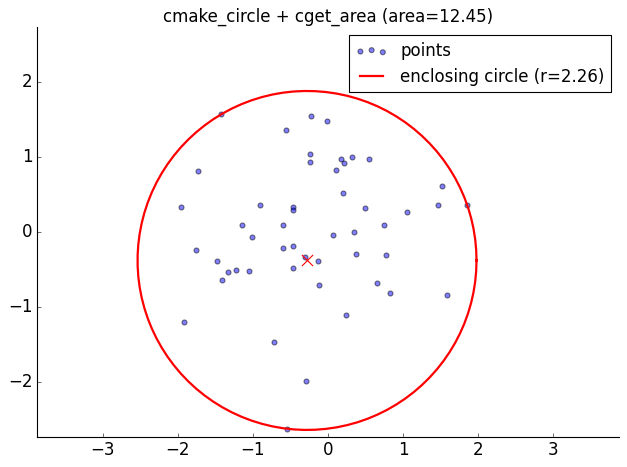

In [13]:
from matviz.circle_utils import cmake_circle, cget_area
from matviz.viz import cplot, cscatter

np.random.seed(42)
z = np.random.randn(50) + 1j * np.random.randn(50)

z_center, r = cmake_circle(z)
area = cget_area(z)

# Plot points and enclosing circle
cscatter(z, alpha=0.5, label='points')
t = np.linspace(0, 2*np.pi, 100)
circle = z_center + r * np.exp(1j * t)
cplot(circle, 'r-', lw=2, label=f'enclosing circle (r={r:.2f})')
cscatter(np.array([z_center]), s=100, c='red', marker='x', zorder=5)

plt.axis('equal')
plt.legend()
title(f'cmake_circle + cget_area (area={area:.2f})')
nicefy()
plt.show()